# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Camera Calibration Using Chessboard Images

### Enviroment Setup

In [78]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import OrderedDict, deque
import math

from moviepy.editor import VideoFileClip
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

# Make a list of calibration images
CALIBRATION_IMG_PATH = r"./camera_cal/"
TEST_IMG_PATH = r"./test_images/"


### Binary Image Creation Functions

In [ ]:

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst



# Step through the list and search for chessboard corners
def extact_obj_and_img_points(image_list):    
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in image_list:       
        img = cv2.imread(fname)
        #print("file: ", fname, ", image shape: ", img.shape) 
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #plt.subplot(121).imshow(gray, cmap="gray")
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
        else:
            print("no chees board corners found in: " + fname)
        
    
    return objpoints, imgpoints





calibration_images = glob.glob(CALIBRATION_IMG_PATH + 'calibration*.jpg')

objpoints, imgpoints = extact_obj_and_img_points(calibration_images)


## Unit Test
for fname in calibration_images:       
    img = cv2.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    objpoints = np.asarray(objpoints)
    imgpoints = np.asarray(imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original ' + fname.split(os.sep)[-1], fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)








In [ ]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output



def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def abs_threshold(gray, thresh=(20, 255)):
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray < thresh[1])] = 1
    return binary


### Thresholded Binary Image Creation

In [ ]:
def lane_line_binary_image(image):
    DEBUG = False
     
    image_dict =  OrderedDict()
    
    image_raw = image
    image_dict["raw"] = image_raw
    image_gray = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)
    image_dict["grayscale"] = image_gray
    image_rgb = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)     
    image_hls = cv2.cvtColor(image_raw, cv2.COLOR_BGR2HLS).astype(np.float)
    
       
    image_hls_s = image_hls[:,:,2]
    image_dict["S of HLS"] = image_hls_s
    mag_threshold_hls_s = mag_thresh(image_hls_s, sobel_kernel=3, mag_thresh=(60, 255))
    image_dict["S of HLS mag (60, 255)"] = mag_threshold_hls_s
    grad_x_hls_s =  abs_sobel_thresh(image_hls_s, orient='x', sobel_kernel=5, thresh=(20, 255))
    image_dict["grad X of S from HLS (20, 255)"] = grad_x_hls_s
    
    image_hls_l = image_hls[:,:,1]
    image_dict["L of HLS"] = image_hls_l
    mag_hls_l =  abs_threshold(image_hls_l, thresh=(35, 255))
    image_dict["mag of L from HLS (35, 255)"] = mag_hls_l


    

    color_binary = np.dstack(( np.zeros_like(grad_x_hls_s), grad_x_hls_s, mag_hls_l))

    combined_binary = np.zeros_like(mag_hls_l)
    combined_binary[(mag_hls_l == 1) & (grad_x_hls_s == 1)] = 1
    image_dict["combined binary"] = combined_binary

    if DEBUG:
        f, axes = plt.subplots(math.ceil(len(image_dict.keys())/2), 2, figsize=(24, 20))
        f.suptitle(image_path.split("/")[-1].split("\\")[-1], fontsize=20)
        
        axes = axes.ravel()
        
        i = 0
        for key in image_dict.keys():
            axes[i].imshow(image_dict[key], cmap="gray")
            axes[i].set_title(key)
            i += 1
            
        
        plt.show()    
        


    return combined_binary
 
      

        
        
        

image_path_list = glob.glob(TEST_IMG_PATH + '*.jpg')

for image_path in image_path_list:
    image = cv2.imread(image_path)
    image = lane_line_binary_image(image) 
    plt.imshow(image, cmap="gray")
    plt.show()

## Perspective Transform

In [ ]:
def lane_line_perspective_transform(image, src = None, dst = None):
    #print(image.shape)
     
    raw_image =  np.copy(image) 
    
    for pt in np.squeeze(src):
        cv2.circle(image, tuple(pt), 15, (0, 255, 0), -1)
        
    for pt in np.squeeze(dst):
        cv2.circle(image, tuple(pt), 10, (0, 0, 255), -1)    
    #plt.imshow(image, cmap='gray')
    #plt.show()
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(raw_image, M, tuple(reversed(image.shape)), flags=cv2.INTER_LINEAR)
    #plt.imshow(warped, cmap='gray')
    #plt.show()
    return warped
    


#image = cv2.cvtColor(cv2.imread(image_path_list[0]), cv2.COLOR_BGR2RGB)

SRC = np.float32([
    [590, 450],
    [700, 450],
    [380, 600],
    [900, 580]

])

DST = np.float32([
    [380, 100],
    [900, 100],
    [380, 600],
    [900, 580]
])


image_path_list = glob.glob(TEST_IMG_PATH + '*.jpg')

for image_path in image_path_list:
    image = cv2.imread(image_path)
    image = lane_line_binary_image(image) 
    image = lane_line_perspective_transform(image, SRC, DST)
    #plt.imshow(image, cmap="gray")
    #plt.show()

### Detect lane pixels and fit to find the lane boundary

left base:349, right base: 906
218.104111452 m 227.314876272 m
(array([  7.53646531e-04,  -8.91403055e-01,   6.23494846e+02]), array([  7.24795804e-04,  -6.76664253e-01,   1.06246383e+03]))


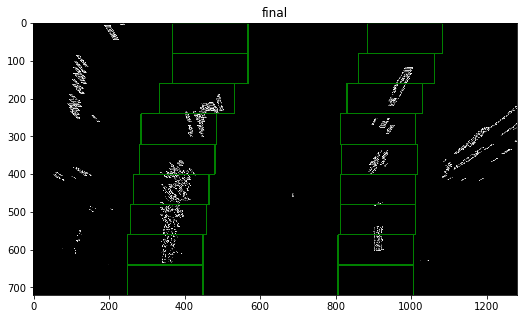

In [69]:
def fit_lane_line(binary_warped):
    
    #print("image size: ", binary_warped.shape)
    
    visualization = False
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print("left base:" + str(leftx_base) + ", right base: " + str(rightx_base))
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,128,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,128,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 
            

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)            

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print("left fit:", left_fit, "right fit:", right_fit)
    
    
    #Measuring Curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])# to cover same y-range as image
    
    
    y_eval = np.max(ploty)

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    #Visualization
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #print(out_img)
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [128, 128,0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 128, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)        
    
    return out_img.astype(np.float), (left_fit, right_fit)


image_path_list = glob.glob(TEST_IMG_PATH + '*.jpg')

for image_path in [image_path_list[6]]:
    image = cv2.imread(image_path)
    image = lane_line_binary_image(image) 
    image = lane_line_perspective_transform(image, SRC, DST)
    image, poly_fit = fit_lane_line(image)
    plt.imshow(image)
    plt.title("final")
    print(poly_fit)
    plt.show()

    
    

## Drawing Cover Polygon on Original Image

In [70]:
def draw_cover(raw_image, Minv, left_poly_coef, right_poly_coef):
    
    color_warp = np.zeros_like(raw_image).astype(np.uint8)
    
    ploty = np.linspace(0, raw_image.shape[0]-1, num = raw_image.shape[0]) # to cover same y-range as image
    
    left_fitx = [left_poly_coef[0] * (y**2) + left_poly_coef[1] * y + left_poly_coef[2] for y in ploty]
    right_fitx = [right_poly_coef[0] * (y**2) + right_poly_coef[1] * y + right_poly_coef[2] for y in ploty]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(raw_image, 1, newwarp, 0.3, 0)
    
    return result
    

## Image Process Pipeline 

left base:388, right base: 875
2837.37857687 m 5082.07989144 m


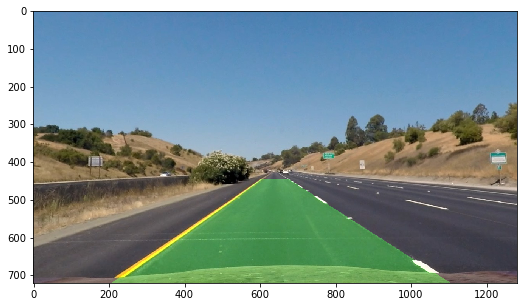

left base:390, right base: 882
1263.47311026 m 4736.99652116 m


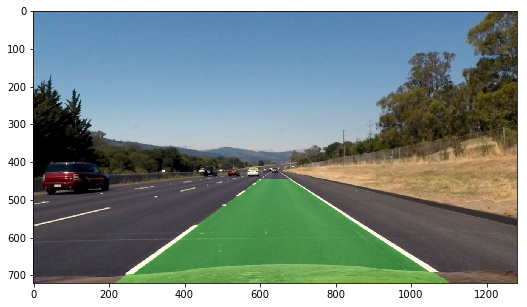

left base:411, right base: 918
295.568832241 m 394.631905141 m


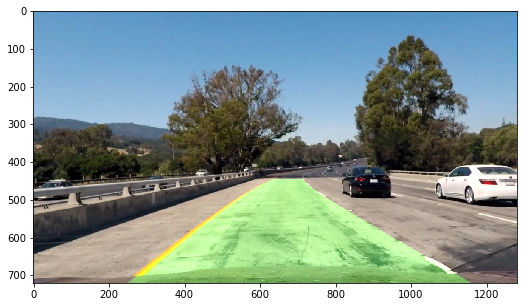

left base:419, right base: 903
296.33409363 m 1181.03012851 m


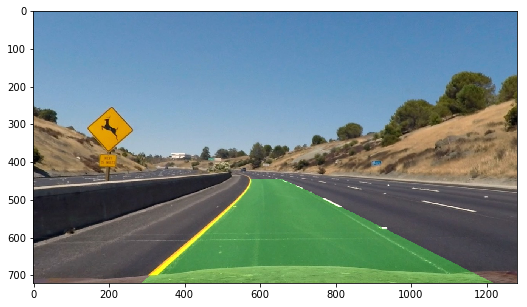

left base:436, right base: 920
1807.04707858 m 371.462724063 m


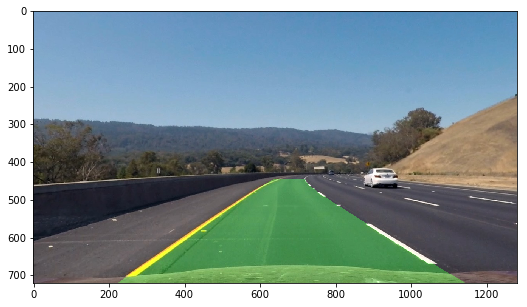

left base:418, right base: 933
1050.94374903 m 343.49031557 m


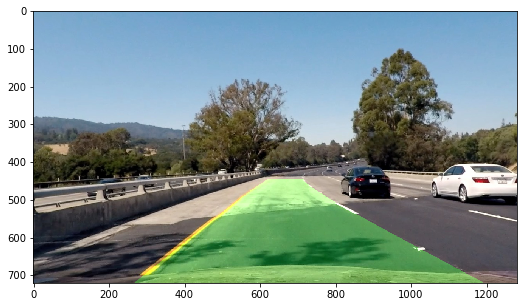

left base:349, right base: 905
227.315681814 m 236.462855797 m


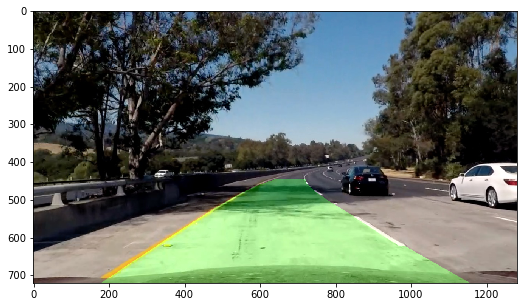

left base:441, right base: 944
1867.26847439 m 495.327130695 m


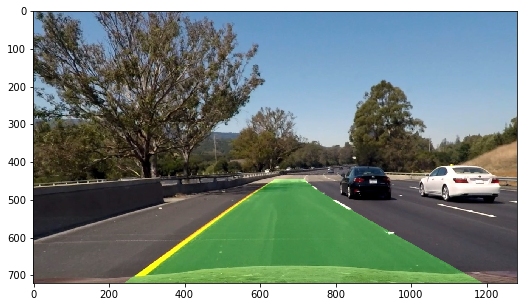

In [74]:
def image_process_pipeline(image):
    SRC = np.float32([
        [590, 450],
        [700, 450],
        [380, 600],
        [900, 580]

    ])

    DST = np.float32([
        [380, 100],
        [900, 100],
        [380, 600],
        [900, 580]
    ])


    image = cal_undistort(image, objpoints, imgpoints)
    undist = np.copy(image)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    image = lane_line_binary_image(image)
    
    M = cv2.getPerspectiveTransform(SRC, DST)
    Minv = cv2.getPerspectiveTransform(DST, SRC)
    
    image = cv2.warpPerspective(image, M, tuple(reversed(image.shape)), flags=cv2.INTER_LINEAR)
    image, (left_poly_coef, right_poly_coef) = fit_lane_line(image)
    
    image = draw_cover(undist, Minv, left_poly_coef, right_poly_coef)
    
    return image
    
image_path_list = glob.glob(TEST_IMG_PATH + '*.jpg')

for image_path in image_path_list:
    image = cv2.imread(image_path)
    image = image_process_pipeline(image)
    plt.imshow(image)
    
    plt.show()
    
    

In [94]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        
        # was the line detected in the last iteration?       
        self.detected = False  
        #
        
        # x values of the last n fits of the line
        self.recent_xfitted = deque()
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def xfitted_append(x):
        if len(self.recent_xfitted) == self.buffer_size:
            self.recent_xfitted.pop()
        
        self.recent_xfitted.append(x)
        self.bestx = np.sum(self.recent_xfitted)/len(self.recent_xfitted)
        
        
            
        

temp = Line(6)
print(temp.recent_xfitted)

deque([[], [], [], [], [], []])


In [ ]:
left_lane = Line(5)
right_lane = Line(5)


def fit_lane_line(binary_warped, left_lane = Line(), right_lane = Line()):
    
    #print("image size: ", binary_warped.shape)
    
    visualization = False
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 100
    
    if left_lane.detected is False or right_lane.detected is False:
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        #print("left base:" + str(leftx_base) + ", right base: " + str(rightx_base))

        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)



        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,128,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,128,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)            
        
        # update the detected status
        if len(left_lane_inds) != 0:
            left_lane.detected = True
        
        if len(right_lane_inds) != 0:
            right_lane.detected = True
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_lane.current_fit = np.polyfit(lefty, leftx, 2)
        right_lane.current_fit = np.polyfit(righty, rightx, 2)

        #print("left fit:", left_fit, "right fit:", right_fit)
    else:

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    
    
    
    #Measuring Curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])# to cover same y-range as image
    
    
    y_eval = np.max(ploty)

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    #Visualization
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #print(out_img)
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [128, 128,0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 128, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)        
    
    return out_img.astype(np.float), (left_fit, right_fit)




## Video Pipe Line

In [ ]:
from IPython.display import HTML

out_video = "output.mp4"

clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(image_process_pipeline)
%time out_clip.write_videofile(out_video, audio=False)

In [98]:
temp = deque()
print(len(temp))
temp.append(5)
print(len(temp))

temp2 = [np.array([False])]  
print(temp2)

0
1
[array([False], dtype=bool)]
